# **Import Initial Library, Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np 

import re 
import datetime
import string

from nltk.corpus import stopwords, gutenberg
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer

np.random.seed(42)

# **Import Data**

In [2]:
data = pd.read_csv('bitcoin_tweets1000000.csv',
                   encoding='ISO-8859-1',
                   index_col=[0])
data.head()

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\1602624160.py:1: DtypeWarning: Columns (0,5,6,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('bitcoin_tweets1000000.csv',


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,CryptoND,NaN,ð BITCOINLIVE is a Dutch platform aimed at ...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"ð Today, that's this #Thursday, we will do ...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,Alex Kirchmaier ð¦ð¹ð¸ðª #FactsSupersp...,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


# **Preprocessing Flow Diagram**

![Data Preprocessing Flow.png](<attachment:Data Preprocessing Flow.png>)
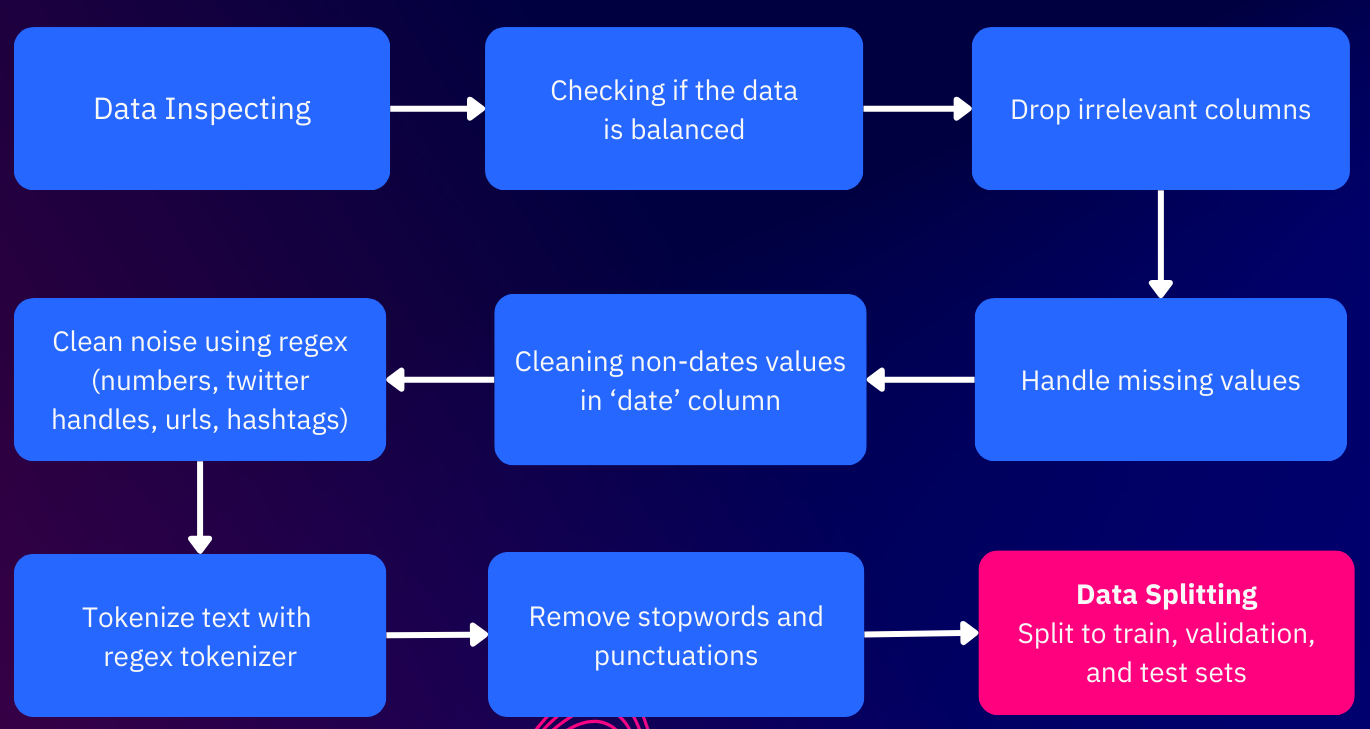

# **1. Data Inspecting**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000025 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   user_name         999980 non-null   object 
 1   user_location     536636 non-null   object 
 2   user_description  889225 non-null   object 
 3   user_created      1000000 non-null  object 
 4   user_followers    1000000 non-null  object 
 5   user_friends      1000000 non-null  object 
 6   user_favourites   999997 non-null   object 
 7   user_verified     999996 non-null   object 
 8   date              999995 non-null   object 
 9   text              999993 non-null   object 
 10  hashtags          983199 non-null   object 
 11  source            996633 non-null   object 
 12  is_retweet        999946 non-null   object 
 13  cleanText         999987 non-null   object 
 14  Polarity Score    999988 non-null   float64
 15  sentiment         999986 non-null   float64
dtypes: flo

In [4]:
print(f'Dataframe has {data.shape[0]} rows and {data.shape[1]} columns')

Dataframe has 1000025 rows and 16 columns


# **2. Checking if the data is balanced**

In [5]:
data['sentiment'].value_counts(normalize=True)

sentiment
0.0    0.527057
1.0    0.472943
Name: proportion, dtype: float64

The value counts above indicates 53% negative and 47% positive, this dataset is balanced enough

In [6]:
data.describe()

,Polarity Score,sentiment
count,999988.000000,999986.000000
mean,0.144692,0.472943
std,0.271044,0.499268
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.286508,1.000000
max,1.000000,1.000000


#### Counting missing values for each columns

In [7]:
data.isna().sum()

user_name               45
user_location       463389
user_description    110800
user_created            25
user_followers          25
user_friends            25
user_favourites         28
user_verified           29
date                    30
text                    32
hashtags             16826
source                3392
is_retweet              79
cleanText               38
Polarity Score          37
sentiment               39
dtype: int64

# *Data Cleaning*

#### Checkpoint 1

In [8]:
df = data.copy()

# **3. Dropping irrelevant columns**

In [9]:
df = df.drop(['user_created',
               'cleanText', 
               'user_location',
               'user_description'],
               axis=1)

# **4. Handling Missing Values**

In [10]:
df = df.dropna(subset=['text',
                       'date',
                       'sentiment'])
print(f'Dataframe has {df.shape[0]} rows and {df.shape[1]} columns')
df.isna().sum()

Dataframe has 999986 rows and 12 columns


user_name             20
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags           16792
source              3357
is_retweet            43
Polarity Score         0
sentiment              0
dtype: int64

# **5. Cleaning non-dates values in 'date' column**

It seems like we have non-dates going into the `date` column, we will have to clean the non-dates values

In [12]:
df[df['date'].str.contains('ETH|BTC|Bitcoin|btc')]

,user_name,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Polarity Score,sentiment
64943,Can roam the worldï¼It's nine to five againáµ...,36.0,False,2021-04-07 16:23:03,@krakenfx #ETH #BTC If you want to become po...,"['ETH', 'BTC', 'Bitcoin']",Twitter Web App,False,NaN,NaN,0.0,0.0
137068,*Muhammad Yasir* hello stalker nice to tweet ...,499.0,False,2021-06-23 14:51:12,Official ESHOP Airdrop. If You Missed Meme Tok...,"['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum...",Twitter for Android,False,NaN,NaN,0.0,0.0
180575,â¢ Learn n To Do d'Best...!!!!!!!!,127.0,False,2021-06-22 13:31:16,@pufferswap Nice project\n\n@karnoto_hendrik \...,"['YieldFarming', 'Airdrop', 'Binance', 'Bitcoi...",Twitter Web App,False,NaN,NaN,0.0,0.0
693194,FB- Xiomara CastaÃ±eda,531.0,False,2021-07-26 11:54:15,#btc to the moon ðð 77774,['btc'],Twitter Web App,False,NaN,NaN,0.0,0.0
697397,Pin bb : 26ea62f8 . Line : baliratih_bali,21.0,False,2021-07-26 11:48:46,#btc to the moon ðð 46059,['btc'],Twitter Web App,False,NaN,NaN,0.0,0.0


Dropping rows where contains non-dates

In [13]:
df = df[~df['date'].str.contains('ETH|BTC|Bitcoin|btc')].reset_index(drop=True)

Transforming text-date into date format

In [14]:
df['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in df['date']]
df['date'] = pd.to_datetime(df['date']).dt.date

In [15]:
df['date'].min(), df['date'].max()

(datetime.date(2021, 2, 5), datetime.date(2021, 8, 21))

### Checkpoint 2

In [16]:
df_datetime_transformed = df.copy()

In [17]:
df_datetime_transformed['is_retweet']\
    .fillna(value='n/a', inplace=True)
df_datetime_transformed['is_retweet']\
    [df_datetime_transformed['is_retweet']=='n/a']

228484    n/a
240487    n/a
316612    n/a
378314    n/a
398478    n/a
398690    n/a
398713    n/a
398735    n/a
398746    n/a
398757    n/a
398768    n/a
398781    n/a
419329    n/a
580673    n/a
583956    n/a
588615    n/a
594250    n/a
622707    n/a
630074    n/a
633036    n/a
635732    n/a
636715    n/a
643985    n/a
651471    n/a
651768    n/a
677568    n/a
678698    n/a
679892    n/a
683595    n/a
703619    n/a
718112    n/a
737915    n/a
738139    n/a
808565    n/a
813973    n/a
864605    n/a
870423    n/a
875886    n/a
Name: is_retweet, dtype: object

Making sure we filled the right rows

In [18]:
len(df_datetime_transformed['is_retweet']\
    [df_datetime_transformed['is_retweet']=='n/a'])

38

In [19]:
len(df['is_retweet'].isna()\
    [df['is_retweet'].isna()==True])

38

### Checkpoint 3

In [20]:
df_c3 = df_datetime_transformed.copy()

# **6. Clean noise values using REGEX**

In [21]:
text_df = df_c3[['date', 'text', 'is_retweet','sentiment']]
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        999981 non-null  object 
 1   text        999981 non-null  object 
 2   is_retweet  999981 non-null  object 
 3   sentiment   999981 non-null  float64
dtypes: float64(1), object(3)
memory usage: 30.5+ MB


In [22]:
text_df['text'][1]

'ð\x9f\x98\x8e Today, that\'s this #Thursday, we will do a "ð\x9f\x8e¬ Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expeâ\x80¦ https://t.co/go6aDgRml5'

We will handle these text using regex

Ther is a lot of noise in the data so we will have to clean them for examples urls and Twitter handles

In [23]:
#url pattern we want to remove
pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
print(re.findall(pattern, text_df['text'][0]))

pattern = "(http|ftp|https):\/\/(t.co\/[a-zA-Z0-9\-\.]{8})"
print(re.findall(pattern, text_df['text'][0]))

pattern = "https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
print(re.findall(pattern, text_df['text'][0]))

# apostrophe pattern
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
print(re.findall(pattern, text_df['text'][0]))

[('https', 't.co', '/xaaZmaJKiV'), ('https', 't.co', '/sgBxMkP1SI')]
[('https', 't.co/xaaZmaJK'), ('https', 't.co/sgBxMkP1')]
['https://t.co/xaaZmaJK', 'https://t.co/sgBxMkP1']
['Blue', 'Ridge', 'Bank', 'shares', 'halted', 'by', 'NYSE', 'after', 'bitcoin', 'ATM', 'announcement', 'https', 't', 'co', 'xaaZmaJKiV', 'MyBlueRidgeBank', 'https', 't', 'co', 'sgBxMkP', 'SI']


## Removing urls

In [24]:
https_pattern = r"https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
www_pattern = r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)"
repl = ""

text_df.loc[:, 'text'] = text_df['text']\
    .apply(lambda string: re.sub(https_pattern,
                                 repl,
                                 string,
                                 count=0,
                                 flags=0))
text_df.loc[:, 'text'] = text_df['text']\
    .apply(lambda string: re.sub(www_pattern,
                                 repl,
                                 string,
                                 count=0, 
                                 flags=0))

print(text_df['text'][1])

ð Today, that's this #Thursday, we will do a "ð¬ Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expeâ¦ l5


## Removing Twitter Handles

In [25]:
handle_pattern = r"@[A-Za-z0-9]+"
repl = ""

text_df.loc[:, 'text'] = text_df['text']\
    .apply(lambda string: re.sub(handle_pattern,
                                 repl, 
                                 string, 
                                 count=0, 
                                 flags=0))

## Removing numbers

In [26]:
num_pattern = r"\b\d+\b"
repl = ""

text_df.loc[:, 'text'] = text_df['text']\
    .apply(lambda string: re.sub(num_pattern, 
                                 repl, 
                                 string, 
                                 count=0, 
                                 flags=0))

In [27]:
text_df.head()

,date,text,is_retweet,sentiment
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,False,0.0
1,2021-02-10,"ð Today, that's this #Thursday, we will do ...",False,0.0
2,2021-02-10,"Guys evening, I have read this article about B...",False,0.0
3,2021-02-10,$BTC A big chance in a billion! Price: \. (// ...,False,0.0
4,2021-02-10,This network is secured by nodes as of today...,False,0.0


# **7. Tokenize Text with Regex Tokenizer**

Converting text into lower so the model don't treat different casing as different words

In [28]:
text_df.loc[:, 'text'] = text_df['text'].str.lower()

In [29]:
tweet_tokenizer = TweetTokenizer()
tweet_tokenizer.tokenize(text_df['text'][3])

['$',
 'btc',
 'a',
 'big',
 'chance',
 'in',
 'a',
 'billion',
 '!',
 'price',
 ':',
 '\\',
 '.',
 '(',
 '/',
 '/',
 ':)',
 '#bitcoin',
 '#fx',
 '#btc',
 '#crypto']

In [30]:
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
tokenizer.tokenize(text_df['text'][3])

['btc',
 'big',
 'chance',
 'in',
 'billion',
 'price',
 'bitcoin',
 'fx',
 'btc',
 'crypto']

We will go with the regex tokenizer since it seems it isolate key words better

In [31]:
text_df['tokenized_text'] = text_df['text'].apply(tokenizer.tokenize)

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\1446832684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['tokenized_text'] = text_df['text'].apply(tokenizer.tokenize)


In [32]:
# abbreviation dictionary
abbv_dict = {'btc': 'bitcoin', 
             'ethereum': 'eth', 
             'cryptocurrency': 'crypto', 
             'dogecoin': 'doge'}

# tokenized text back to single string for functionality
text_df.loc[:, 'text2'] = [" ".join(lst) for lst in text_df['tokenized_text']]

# replacing key with value
for key in abbv_dict.keys():
    text_df.loc[:, 'text2'] = text_df['text2'].apply(lambda text_str: text_str.replace(key, abbv_dict[key]))

# before and after    
print(text_df['text'][1])
print(text_df['text2'][1])

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\2521372626.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.loc[:, 'text2'] = [" ".join(lst) for lst in text_df['tokenized_text']]


ð today, that's this #thursday, we will do a "ð¬ take " with our friend , #btc #wallet #security expeâ¦ l5
today that this thursday we will do take with our friend bitcoin wallet security expeâ l5


In [33]:
print(text_df['text'][20000])
print(text_df['text2'][20000])

this is a nice setup for #btc to make a run back to ath. #bitcoin x5
this is nice setup for bitcoin to make run back to ath bitcoin x5


Tokenizing text2

In [34]:
text_df.loc[:, 'tokenized_text'] = text_df["text2"].apply(tokenizer.tokenize)

Creating columng that contains all the hashtags in each tweets

In [35]:
text_df.loc[:, 'hashtags'] = text_df['text']\
    .apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\3389650317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.loc[:, 'hashtags'] = text_df['text']\


In [36]:
text_df.head()

,date,text,is_retweet,sentiment,tokenized_text,text2,hashtags
0,2021-02-10,blue ridge bank shares halted by nyse after #b...,False,0.0,"[blue, ridge, bank, shares, halted, by, nyse, ...",blue ridge bank shares halted by nyse after bi...,[#bitcoin]
1,2021-02-10,"ð today, that's this #thursday, we will do ...",False,0.0,"[today, that, this, thursday, we, will, do, ta...",today that this thursday we will do take with ...,"[#thursday, #btc, #wallet, #security]"
2,2021-02-10,"guys evening, i have read this article about b...",False,0.0,"[guys, evening, have, read, this, article, abo...",guys evening have read this article about bitc...,[]
3,2021-02-10,$btc a big chance in a billion! price: \. (// ...,False,0.0,"[bitcoin, big, chance, in, billion, price, bit...",bitcoin big chance in billion price bitcoin fx...,"[#bitcoin, #fx, #btc, #crypto]"
4,2021-02-10,this network is secured by nodes as of today...,False,0.0,"[this, network, is, secured, by, nodes, as, of...",this network is secured by nodes as of today s...,[#btc]


# **8. Removing stopwords and punctuation**

In [37]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [38]:
def remove_stopwords(token_list):
    filtered = [word for word in token_list if word not in stopwords_list]  
    return " ".join(filtered)

In [39]:
# applying remove stopwords function
text_df.loc[:, "text_without_stopwords"] = text_df["tokenized_text"].apply(remove_stopwords)

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\2231936551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.loc[:, "text_without_stopwords"] = text_df["tokenized_text"].apply(remove_stopwords)


# *Additional*

Counting for how many hashtag there is in a single tweet

In [40]:
text_df.loc[:, 'hashtag_count'] = text_df['hashtags'].apply(len)

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\1997535160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.loc[:, 'hashtag_count'] = text_df['hashtags'].apply(len)


Counting the tweet length

In [41]:
text_df.loc[:, 'tweet_length'] = text_df['tokenized_text'].apply(len)

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\3414855913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.loc[:, 'tweet_length'] = text_df['tokenized_text'].apply(len)


Showing if the tweet contains a price or not

In [42]:
price_query = r'\$(?:\d{1,3}[,.]?)+(?:\\d{1,2})?'
text_df.loc[:, "contains_price"] = text_df["text"].str.contains(price_query)

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\45996142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.loc[:, "contains_price"] = text_df["text"].str.contains(price_query)


In [43]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    999981 non-null  object 
 1   text                    999981 non-null  object 
 2   is_retweet              999981 non-null  object 
 3   sentiment               999981 non-null  float64
 4   tokenized_text          999981 non-null  object 
 5   text2                   999981 non-null  object 
 6   hashtags                999981 non-null  object 
 7   text_without_stopwords  999981 non-null  object 
 8   hashtag_count           999981 non-null  int64  
 9   tweet_length            999981 non-null  int64  
 10  contains_price          999981 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 77.2+ MB


In [44]:
text_df.head()

,date,text,is_retweet,sentiment,tokenized_text,text2,hashtags,text_without_stopwords,hashtag_count,tweet_length,contains_price
0,2021-02-10,blue ridge bank shares halted by nyse after #b...,False,0.0,"[blue, ridge, bank, shares, halted, by, nyse, ...",blue ridge bank shares halted by nyse after bi...,[#bitcoin],blue ridge bank shares halted nyse bitcoin atm...,1,13,False
1,2021-02-10,"ð today, that's this #thursday, we will do ...",False,0.0,"[today, that, this, thursday, we, will, do, ta...",today that this thursday we will do take with ...,"[#thursday, #btc, #wallet, #security]",today thursday take friend bitcoin wallet secu...,4,16,False
2,2021-02-10,"guys evening, i have read this article about b...",False,0.0,"[guys, evening, have, read, this, article, abo...",guys evening have read this article about bitc...,[],guys evening read article bitcoin would like s...,0,18,False
3,2021-02-10,$btc a big chance in a billion! price: \. (// ...,False,0.0,"[bitcoin, big, chance, in, billion, price, bit...",bitcoin big chance in billion price bitcoin fx...,"[#bitcoin, #fx, #btc, #crypto]",bitcoin big chance billion price bitcoin fx bi...,4,10,False
4,2021-02-10,this network is secured by nodes as of today...,False,0.0,"[this, network, is, secured, by, nodes, as, of...",this network is secured by nodes as of today s...,[#btc],network secured nodes today soon biggest bears...,1,22,False


In [45]:
text_df.iloc[97, :]

date                                                             2021-02-10
text                      ð prices update in $usd ( hour):\n\n$btc   ...
is_retweet                                                            False
sentiment                                                               0.0
tokenized_text            [prices, update, in, usd, hour, bitcoin, eth, ...
text2                          prices update in usd hour bitcoin eth xrp vr
hashtags                                                                 []
text_without_stopwords            prices update usd hour bitcoin eth xrp vr
hashtag_count                                                             0
tweet_length                                                              9
contains_price                                                        False
Name: 97, dtype: object

In [46]:
print(len(text_df) - len(text_df[text_df['text_without_stopwords']=='']))
text_df = text_df[text_df['text_without_stopwords'] != '']
print(len(text_df))

999980
999980


In [47]:
from sklearn.model_selection import train_test_split 

In [48]:
preprocessed_tweets = text_df

In [49]:
preprocessed_tweets['sentiment'].value_counts(normalize=True), len(preprocessed_tweets)

(sentiment
 0.0    0.527055
 1.0    0.472945
 Name: proportion, dtype: float64,
 999980)

In [50]:
preprocessed_tweets.columns.values

array(['date', 'text', 'is_retweet', 'sentiment', 'tokenized_text',
       'text2', 'hashtags', 'text_without_stopwords', 'hashtag_count',
       'tweet_length', 'contains_price'], dtype=object)

In [51]:
preprocessed_tweets = preprocessed_tweets[['date', 'text', 'is_retweet', 'tokenized_text',
       'text2', 'hashtags', 'text_without_stopwords', 'hashtag_count',
       'tweet_length', 'contains_price', 'sentiment']]

In [52]:
preprocessed_tweets['labels'] = preprocessed_tweets['sentiment']
preprocessed_tweets.drop(['sentiment'], axis=1, inplace=True) 
preprocessed_tweets['labels'] = preprocessed_tweets['labels'].astype(int)

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_14296\1927248307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_tweets['labels'] = preprocessed_tweets['sentiment']


## Export preprocessed dataset

In [53]:
preprocessed_tweets.to_csv("preprocessed_tweets.csv",index=False)